# Guassian mixture intra-song clustering for identification of "main" beats

Code for doing tests

In [60]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
from groove.embedding import bar_embedding, load_bar_embedding, load_bar_embedding_total, bar_embedding_total
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points, find_closest_indices
import groove


def simulate_num_components(data, num_trials, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False):
    counts = {}
    for _ in range(num_trials):
        n_components = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights).means_.shape[0]
        if n_components in counts:
            counts[n_components] += 1
        else:
            counts[n_components] = 1
    return counts




def do_clustering(data, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False, verbose=False):
    gm = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights, verbose=verbose)
    print(f"Weights: {gm.weights_}")

    pca = PCA(n_components=2)
    pca.fit(data)
    print(f"PCA values: {pca.singular_values_}")

    return gm, pca

def do_projected_plot(gm, pca, data, confidence=0.9, data_list=None, file_list=None):

    red_data = pca.transform(data)
    patches, _ = get_patches(gm, confidence=confidence, pts=data, pca=pca)

    plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.set_xlim([-.5, .5])
    ax.set_ylim([-.5, .5])

    if data_list != None:
        cmap = plt.cm.get_cmap('hsv', len(data_list) + 1)
        running_total = 0
        legend_patches = []
        for i, d in enumerate(data_list):
            plt.scatter(red_data[running_total:running_total + d.shape[0],0], red_data[running_total:running_total + d.shape[0],1], alpha=0.5, color=cmap(i), s=3)
            running_total += d.shape[0]
            if file_list != None:
                legend_patches.append(mpatches.Patch(color=cmap(i), label=file_list[i][0]))
        if file_list != None:
            ax.legend(handles=legend_patches)
    else:
        plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
    
    for p in patches:
        ax.add_patch(p)

    return patches


from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks
import librosa
from typing import Callable

def do_bar_sample(indices, file, process: Callable, ext="mp3"):
    raw_measures, proc_measures, sr = get_measures(file, process, ext)
    for i in indices:
        raw, proc = raw_measures[i], proc_measures[i]
        #beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
        #clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


        plt.figure(figsize=(20, 4))
        #plt.plot(raw)
        plt.plot(proc)
        #plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
        display(Audio(data=raw, rate=sr))
        #display(Audio(data=raw + clicks, rate=sr))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the file and process data using the embedding

In [3]:
proc_fn = groove.downbeats.smooth_power

divs = np.array([3, 4, 6, 8, 9, 12, 15, 16, 18, 20, 21, 24])
wts = 1/np.sqrt(divs)


file_list = ['milaklaw', '06 Encore A', 'lms', ('09 D\'Angelo - Spanish Joint', 'm4a'), ('03 All the Pretty Girls', 'm4a')]

# Add extension
for i in range(len(file_list)):
    if type(file_list[i]) is not tuple:
        file_list[i] = (file_list[i], "mp3")

data_list = []
for file, ext in file_list:
    data_list.append(load_bar_embedding_total(file, divisions=divs, weights=wts, process=smooth_power, kernel_width=30, ext=ext))
#data_list = [data_mk, data_e, data_lms, data_sj, data_pg]
data = np.concatenate(data_list, axis=0)

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
/home/harrison/erdos/groove_gang/groove/downbeats.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f'inputs/{file}.{ext}')
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/home/harrison/erdos/groove_gang/groove/downbeats.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f'inputs/{file}.{ext}')
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dty

Some rules for choosing the number of components:
1) Start with some number of components.
2) If overlaps between the 95%ile circles contain more than 10% of points, we should reduce.
3) If any circles don't cover 20%, we reduce.

Run some simulations on the number of components.

In [4]:
#simulate_num_components(data, 100)

For visualization, PCA the top two components and project the clusters down

Num components: 10
Failed because some clusters [0.07582938 0.18009479 0.11532385 0.07424961 0.07424961 0.11058452
 0.05371248 0.12006319 0.16113744 0.04897314] beneath required coverage 0.06.
Num components: 9
Failed because some clusters [0.04739336 0.13112164 0.07424961 0.13744076 0.16745656 0.28278041
 0.06951027 0.06951027 0.1042654 ] beneath required coverage 0.06.
Num components: 8
Failed because some clusters [0.25276461 0.18009479 0.16745656 0.05845182 0.17851501 0.13270142
 0.05055292 0.06635071] beneath required coverage 0.06.
Num components: 7
Failed because some clusters [0.16745656 0.08846761 0.17693523 0.31753555 0.22274882 0.11848341
 0.04897314] beneath required coverage 0.06.
Num components: 6
Weights: [0.18167425 0.16903633 0.19588585 0.20695775 0.11532385 0.13112196]
PCA values: [4.2406905  1.50669438]


/tmp/ipykernel_493156/3428444476.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', len(data_list) + 1)


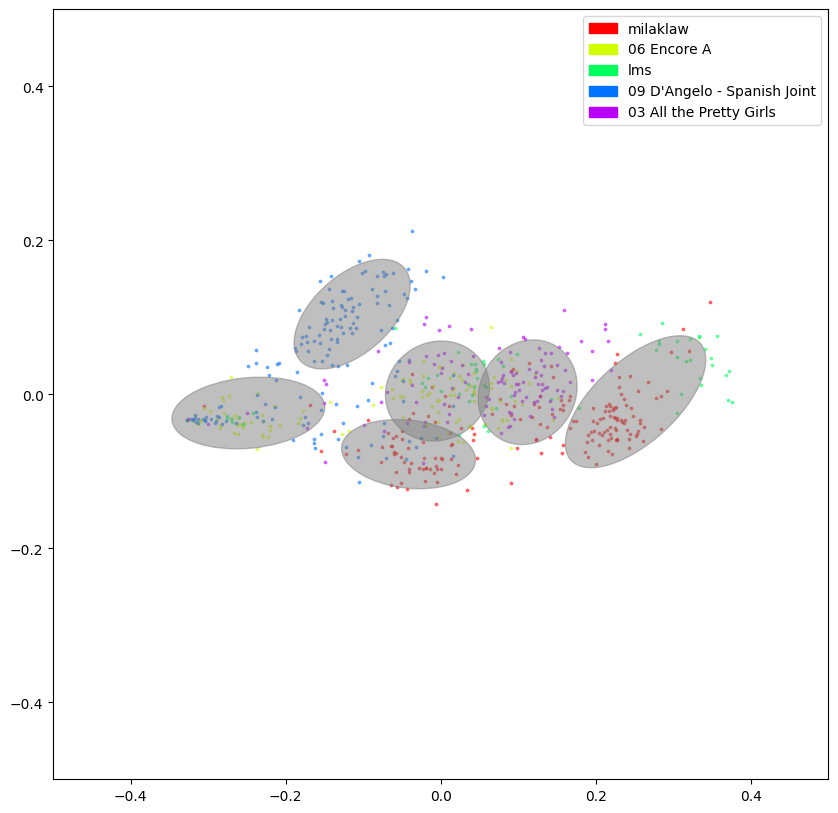

In [61]:
#c = .8
#gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3, overlap_allowance=0.2, use_weights=False, verbose=True)

c = .8
gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3/len(file_list), overlap_allowance=1, use_weights=False, verbose=True)


do_projected_plot(gm, pca, data, c, data_list=data_list, file_list=file_list)

Pick the measures closest to the means of each cluster and play the audio.

Samples from milaklaw


Samples from 06 Encore A


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


Samples from lms


Samples from 09 D'Angelo - Spanish Joint


/home/harrison/erdos/groove_gang/groove/downbeats.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f'inputs/{file}.{ext}')
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Samples from 03 All the Pretty Girls


/home/harrison/erdos/groove_gang/groove/downbeats.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f'inputs/{file}.{ext}')
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


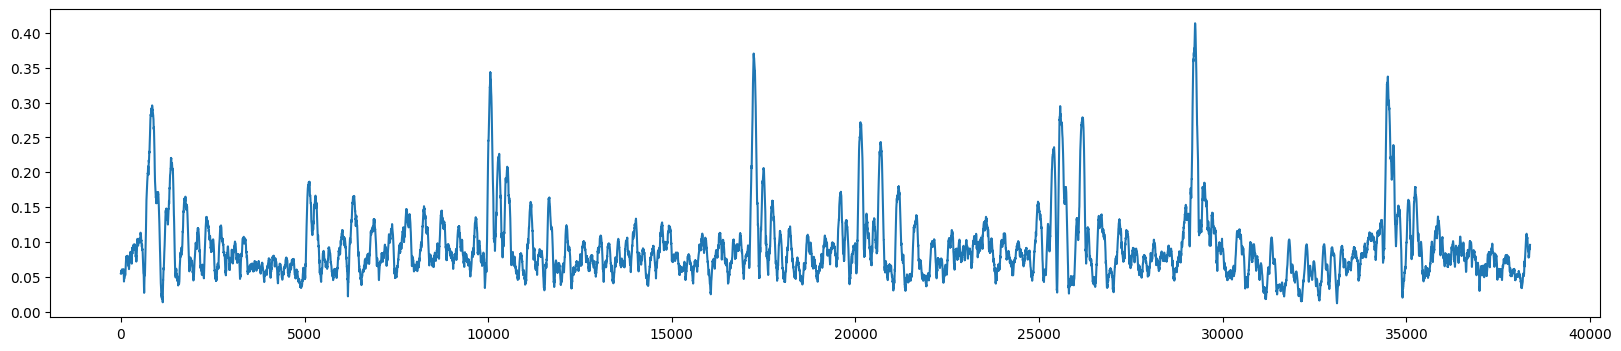

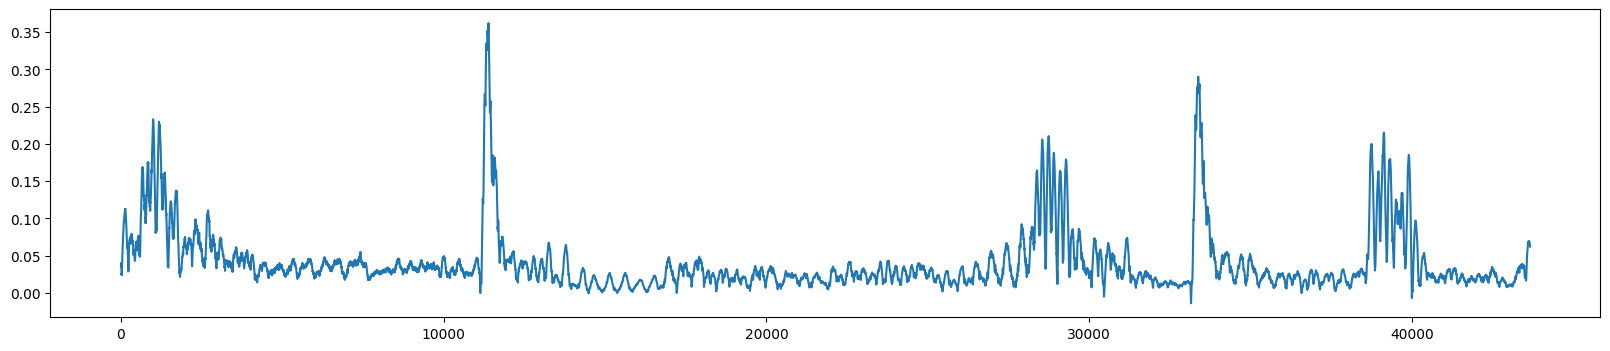

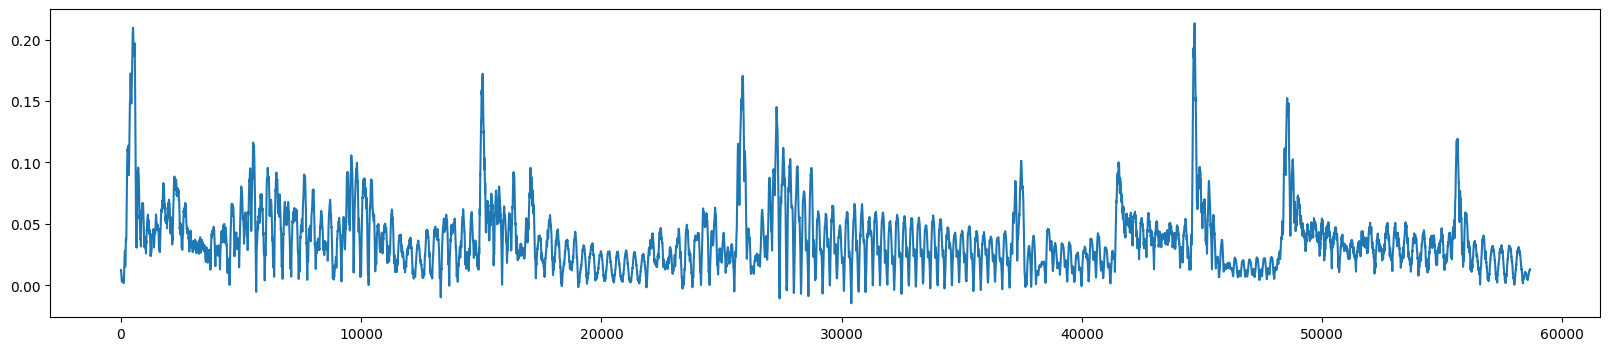

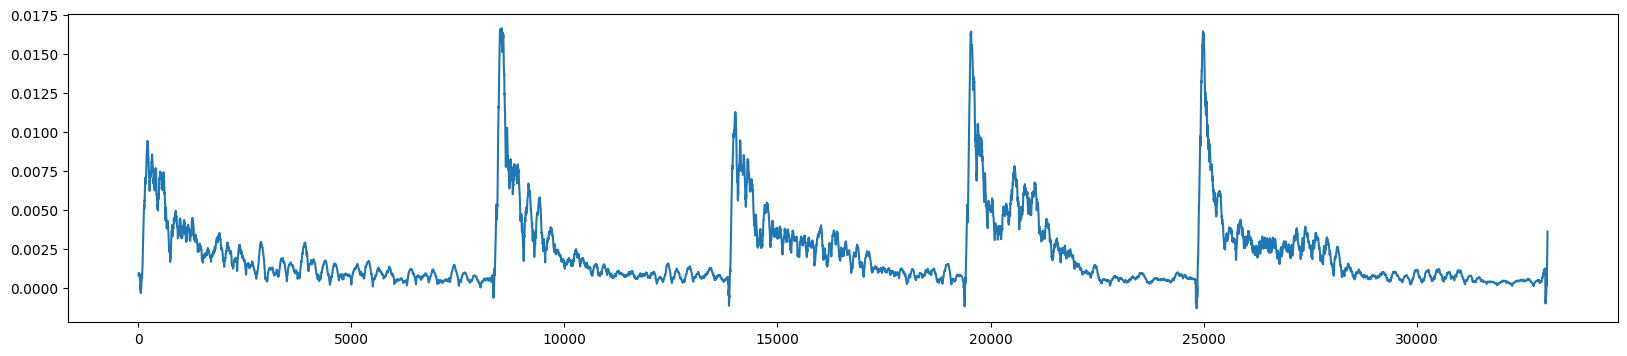

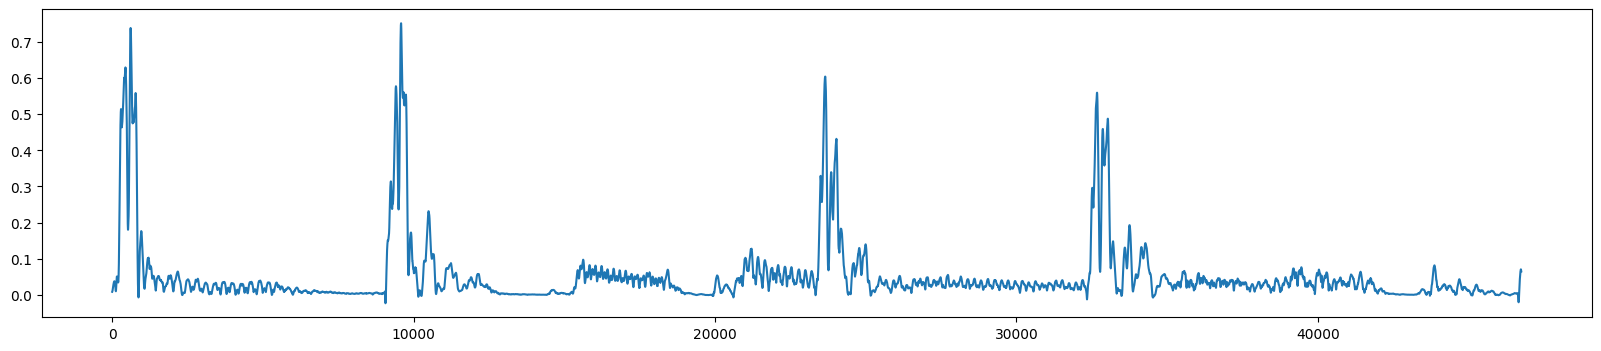

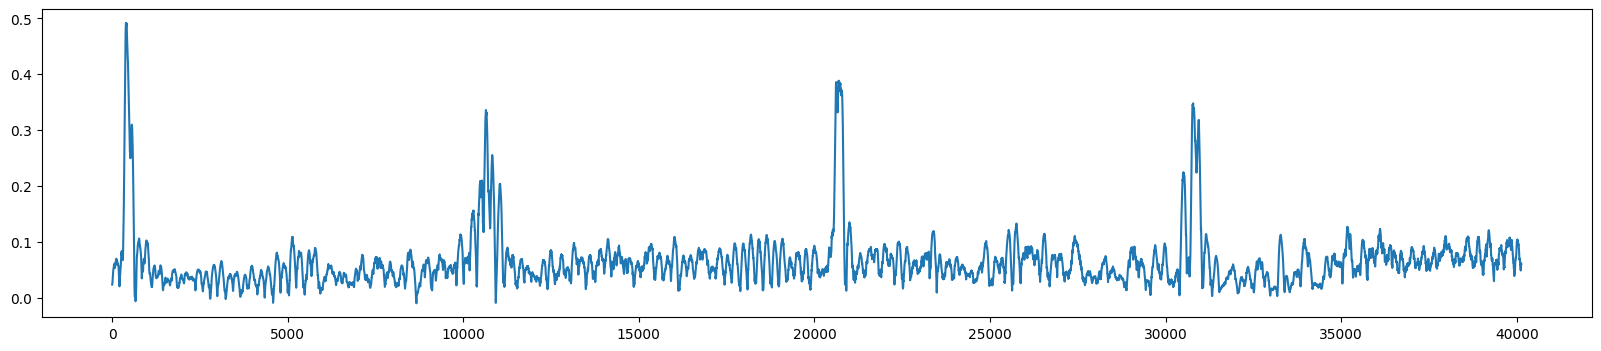

In [62]:
inds = find_closest_indices(gm.means_, data)

starts = [0]
for d in data_list:
    starts.append(starts[-1] + d.shape[0])

#do_bar_sample(inds, file, smooth_power, ext)

for i in range(len(file_list)):
    file, ext = file_list[i]
    print(f"Samples from {file}")
    do_bar_sample(inds[(inds >= starts[i]) & (inds < starts[i+1])] - starts[i], file, smooth_power, ext=ext)

Actual usage

In [ ]:
import numpy as np
from groove.downbeats import smooth_power
from groove.embedding import load_bar_embedding_total
from groove.intraclustering import get_primary_gaussian_mean

file = '06 Encore A'
ext = 'mp3'

divs = np.array([3, 4, 6, 8, 9, 12, 16])
wts = 1/np.sqrt(divs)
data = load_bar_embedding_total(file, divs, wts, smooth_power, ext=ext, concatenate=True)
measure = get_primary_gaussian_mean(data)

print(measure.shape)


[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


(58,)
